# **Visión por Computadora I**

### **Carrera de Especialización en Inteligencia Artificial, Facultad de Ingeniería**

### **Universidad de Buenos Aires, Mayo de 2024**


### Trabajo Práctico II: Edgar David Guarin Castro (davidg@marketpsychdata.com)

## Contenido
* [0. Importando paquetes](#0.-Importando-paquetes)
* [1. Filtros Gaussianos](#1.-Filtros-Gaussianos)
* [2. Filtrado espectral vs Filtrado por convolucion I](#2.-Filtrado-espectral-vs-Filtrado-por-convolucion-I)
* [3. Filtrado espectral vs Filtrado por convolucion II](#3.-Filtrado-espectral-vs-Filtrado-por-convolucion-II)
________________________________

## 0. Importando paquetes

In [57]:
%matplotlib inline
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd

## 1. Filtros Gaussianos

Inicialmente se define la función para la creación de filtros gaussianos que permitan realizar un filtrado espectral a partir del tamaño de un kernel:

In [3]:
def create_gauss_filter(h:int, w:int, k_size:int, sigma:float) -> np.ndarray:
    """
    Creación de filtros gaussianos para filtrado espectral

    ----------
    Parámetros
    ----------
    h,w:int 
        Tamaño de la imagen (height, width)

    k_size:int
        Tamaño del kernel (entero positivo impar)

    sigma:float
        Desvío estándar de la Gaussiana. Si no es positivo, se calcula como sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    
    ----------
    Respuesta
    ----------
    padded_kernel:np.ndarray
        Filtro gaussiano de tamaño HxW en dominio espacial

    fft_kernel:np.ndarray
        Transformada de Fourier del padded_kernel
    """
    # Creando un kernel gaussiano 2D
    kernel  = cv.getGaussianKernel(k_size, sigma, cv.CV_64F) # CV_64F es el tipo de coeficientes del filtro
    kernel_2D = kernel * kernel.T  # Producto externo para crear un kernel 2D
    
    # Ajustando el tamaño del kernel al tamaño de la imagen para luego centrarlos
    gauss_kernel_2D = np.zeros((h, w), dtype=np.float64)
    center_x, center_y = (h - k_size) // 2, (w - k_size) // 2
    gauss_kernel_2D[center_x:center_x + k_size, center_y:center_y + k_size] = kernel_2D
    
    # Calculando la Transformada de Fourier del kernel y desplazandola al centro
    fft_kernel = np.fft.fftshift(np.fft.fft2(gauss_kernel_2D))
    
    return gauss_kernel_2D, fft_kernel

Se carga la imagen a ser tratada y se obtiene su tamaño, el cual será usado para definir el filtro gaussiano:

Tamaño de la imagen: (698, 341) pixeles


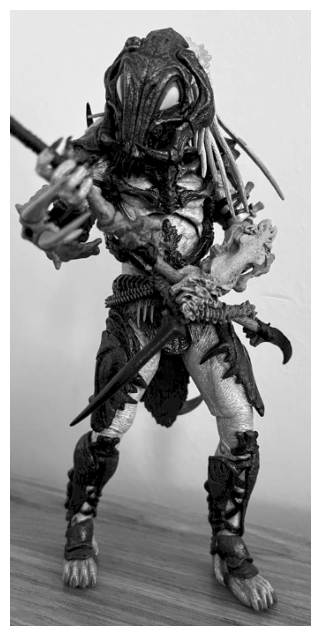

In [4]:
# Cargando la imagen RGB
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)

# Dimensión de la imagen
print(f'Tamaño de la imagen: {img.shape} pixeles')

h, w = img.shape

# Mostrando la imagen
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

A continuación se presenta el filtro Gaussiano (izquierda) y su transformada de Fourier (FFT, derecha) para diferentes tamaños de kernel:

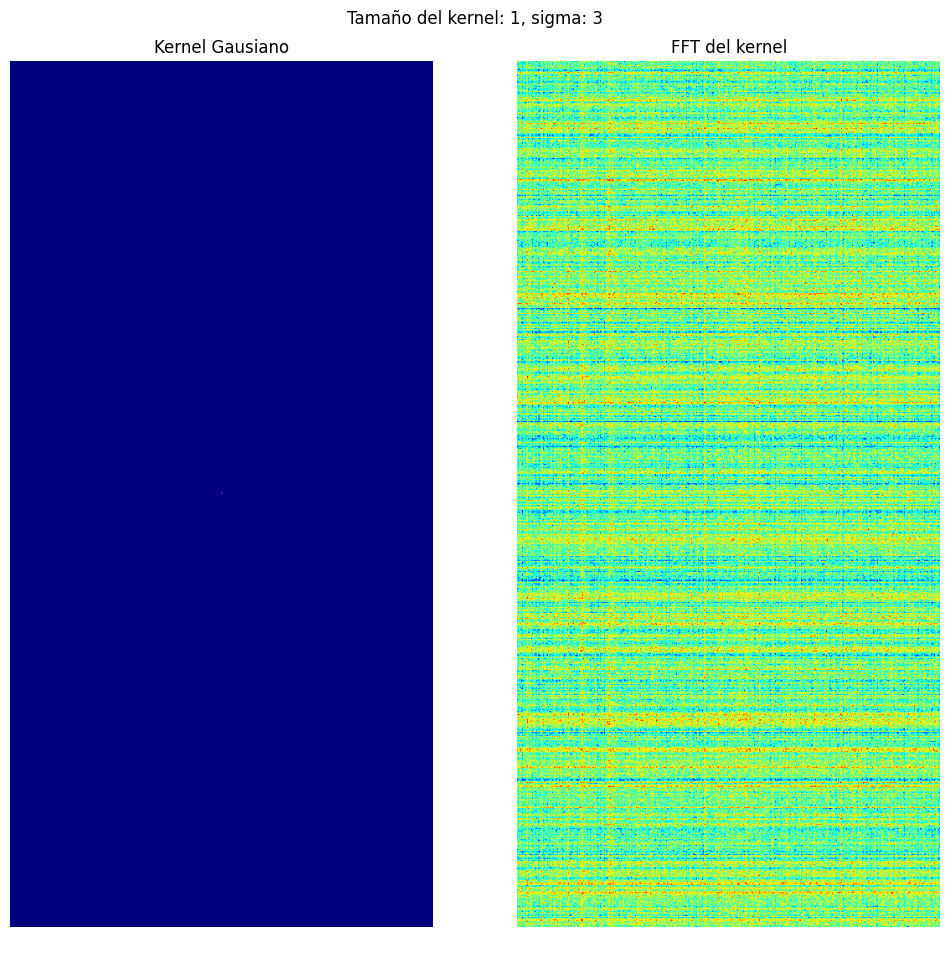

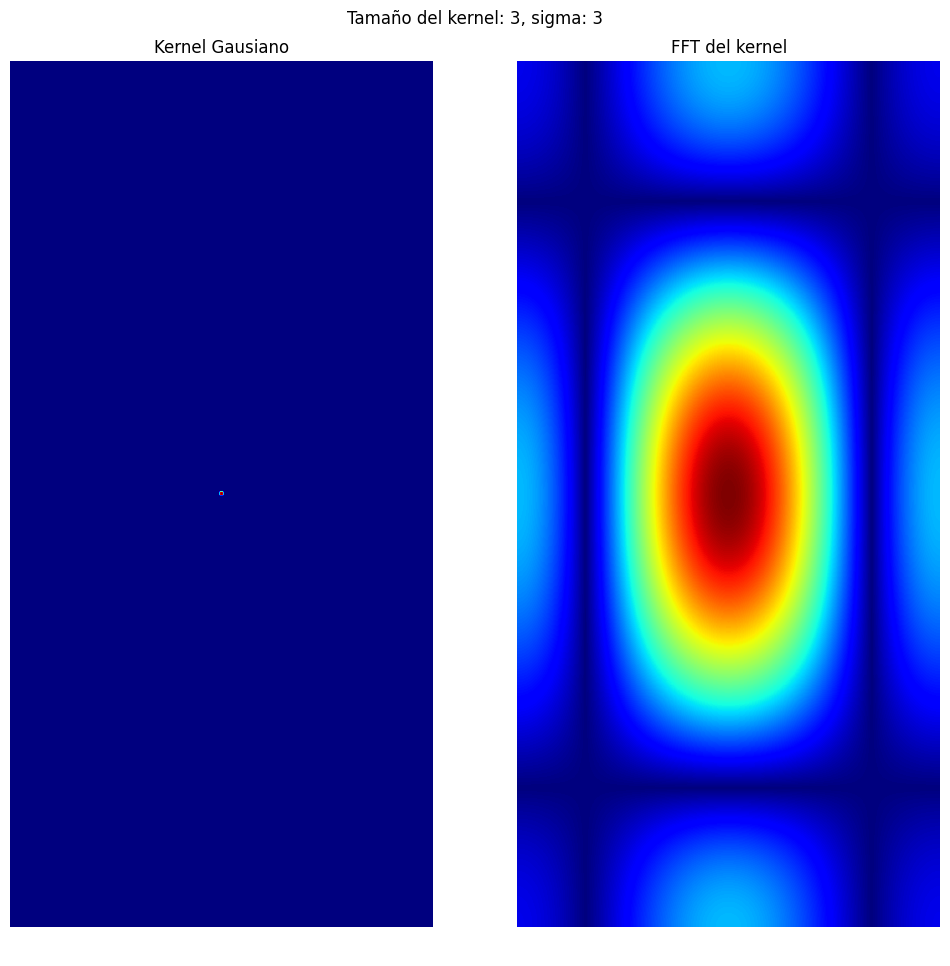

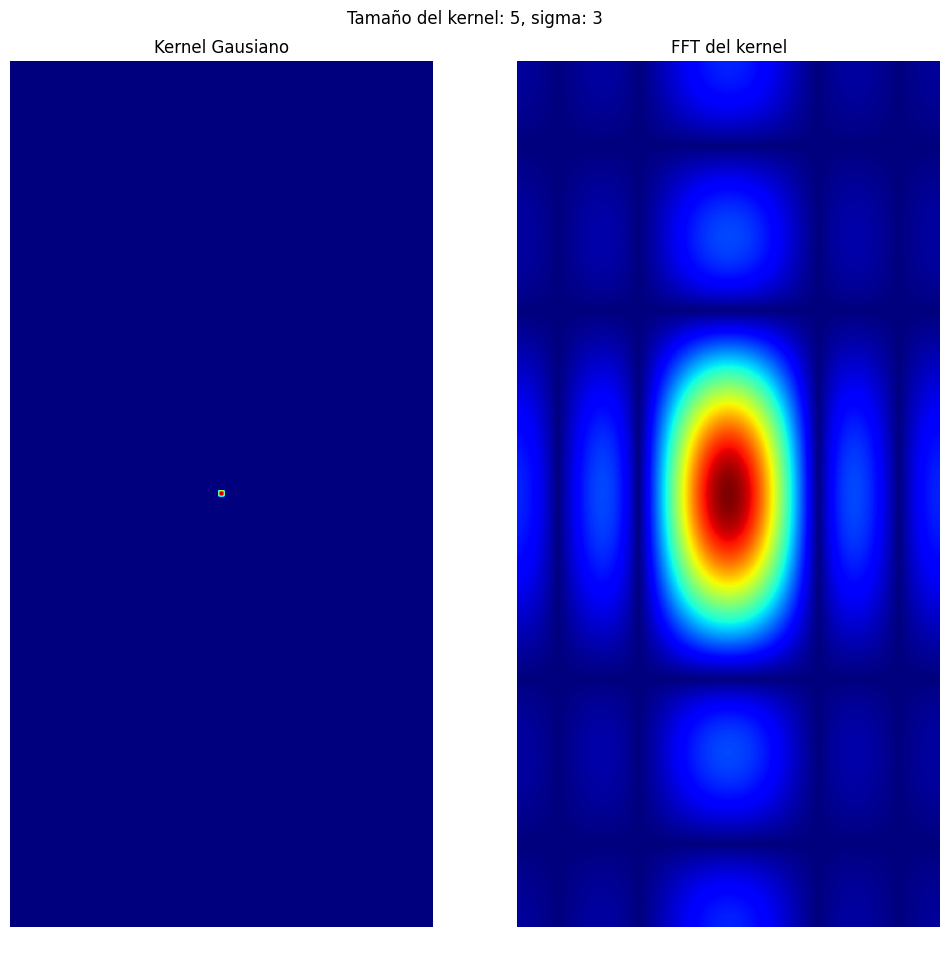

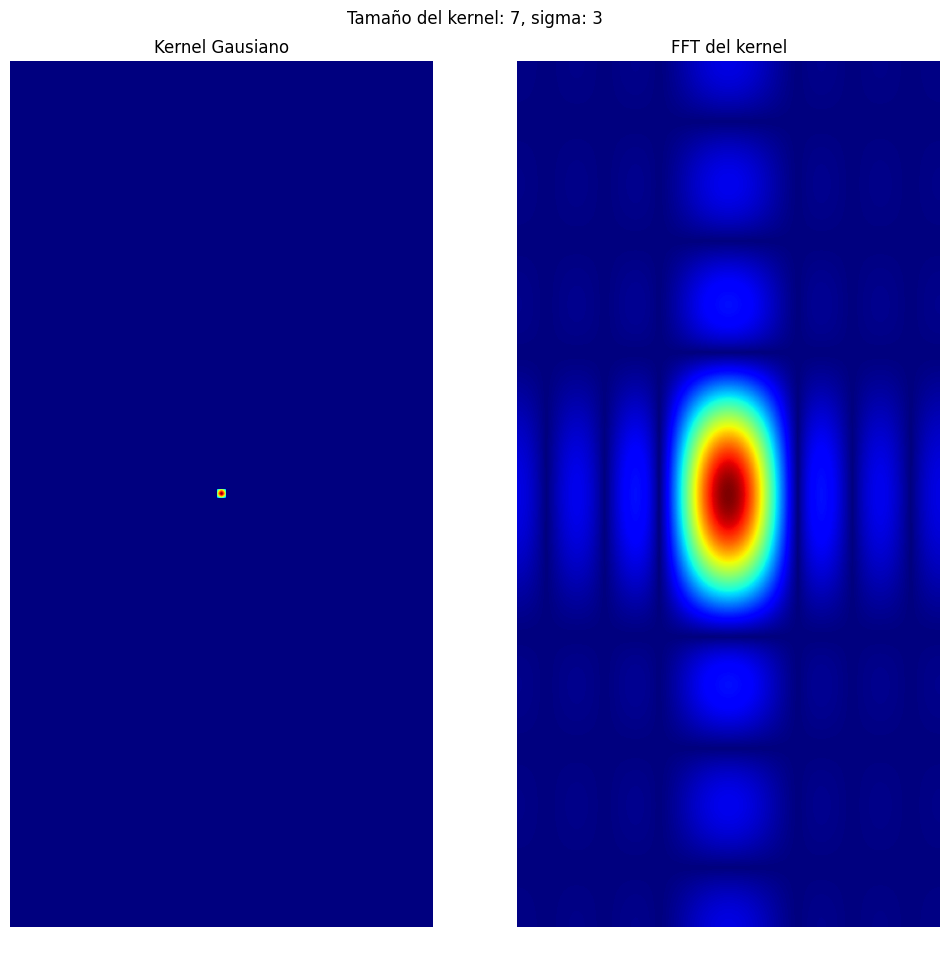

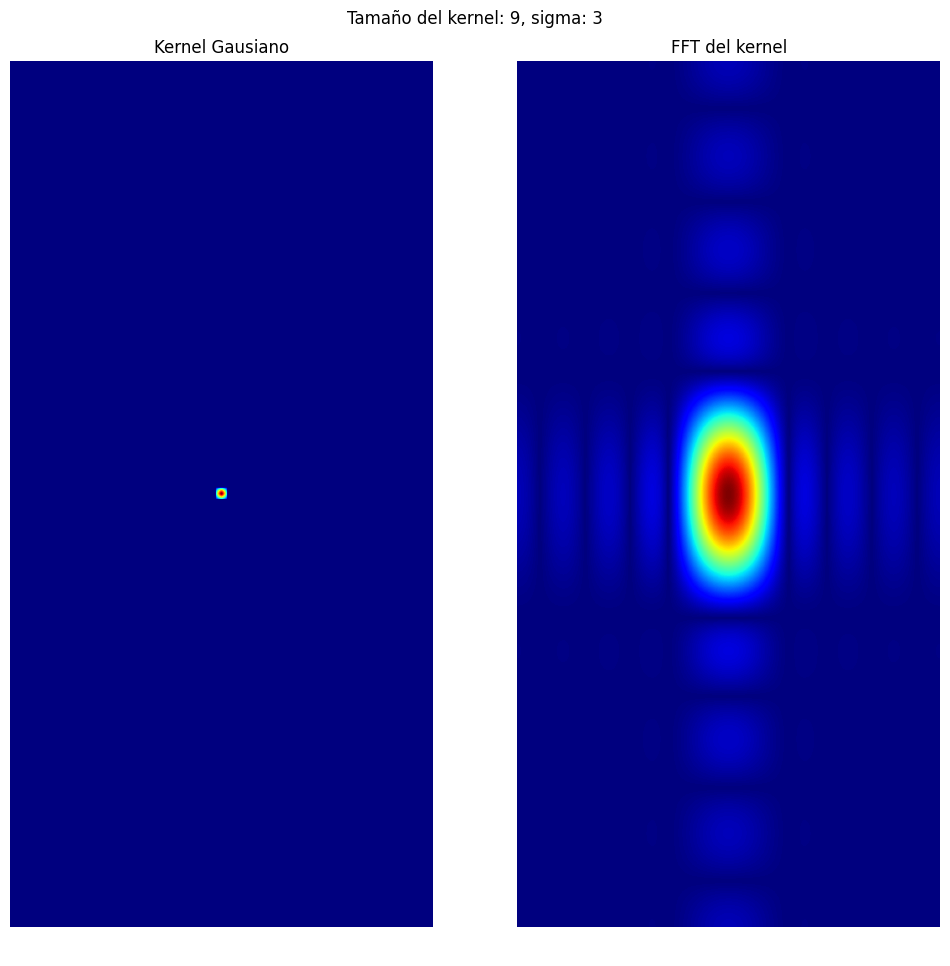

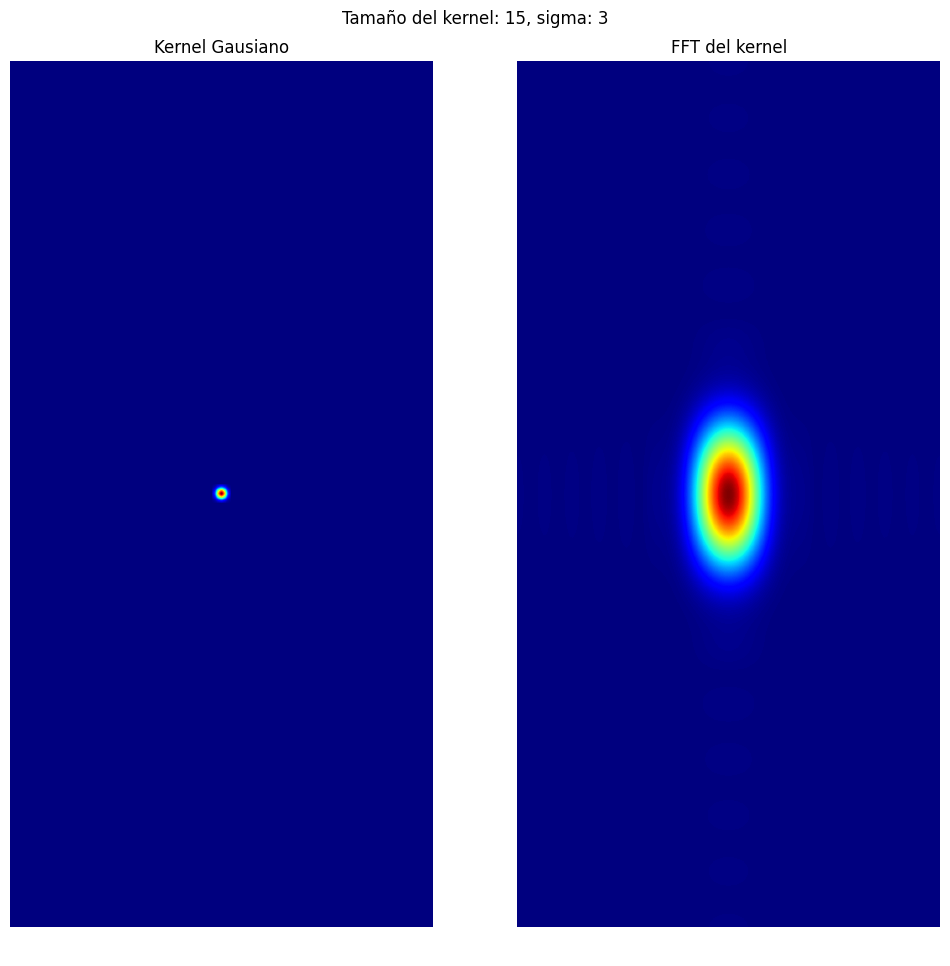

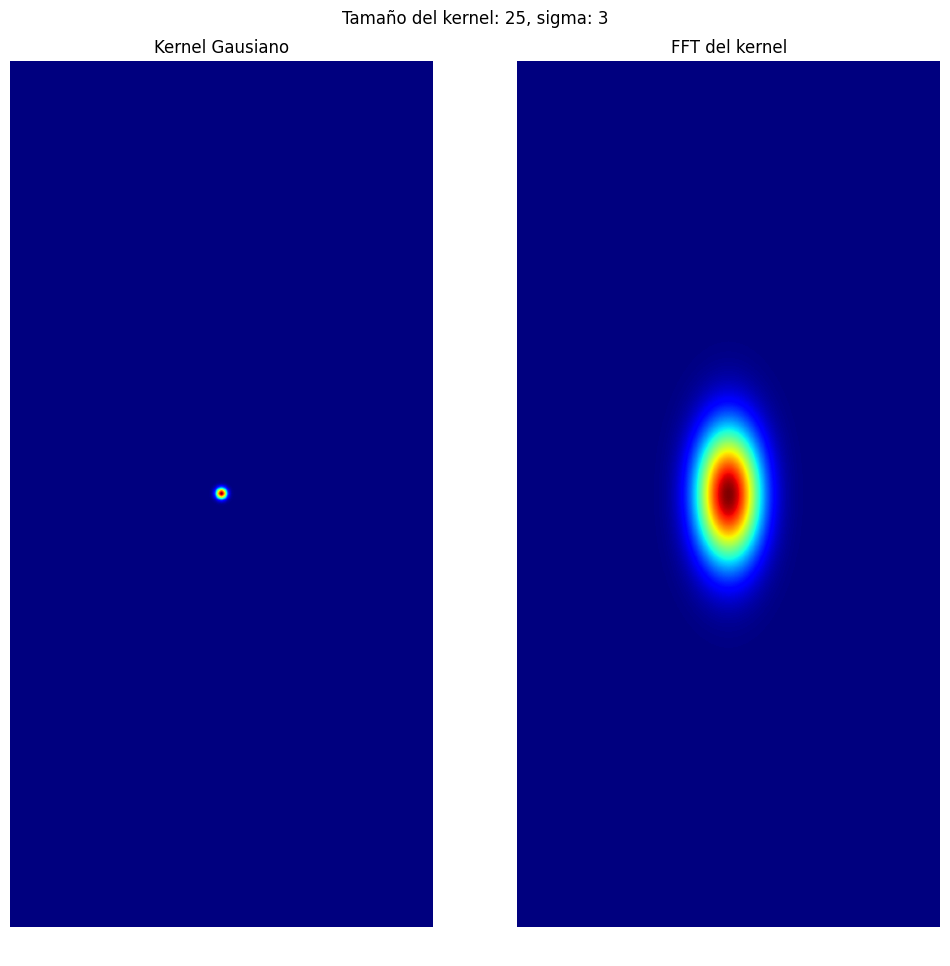

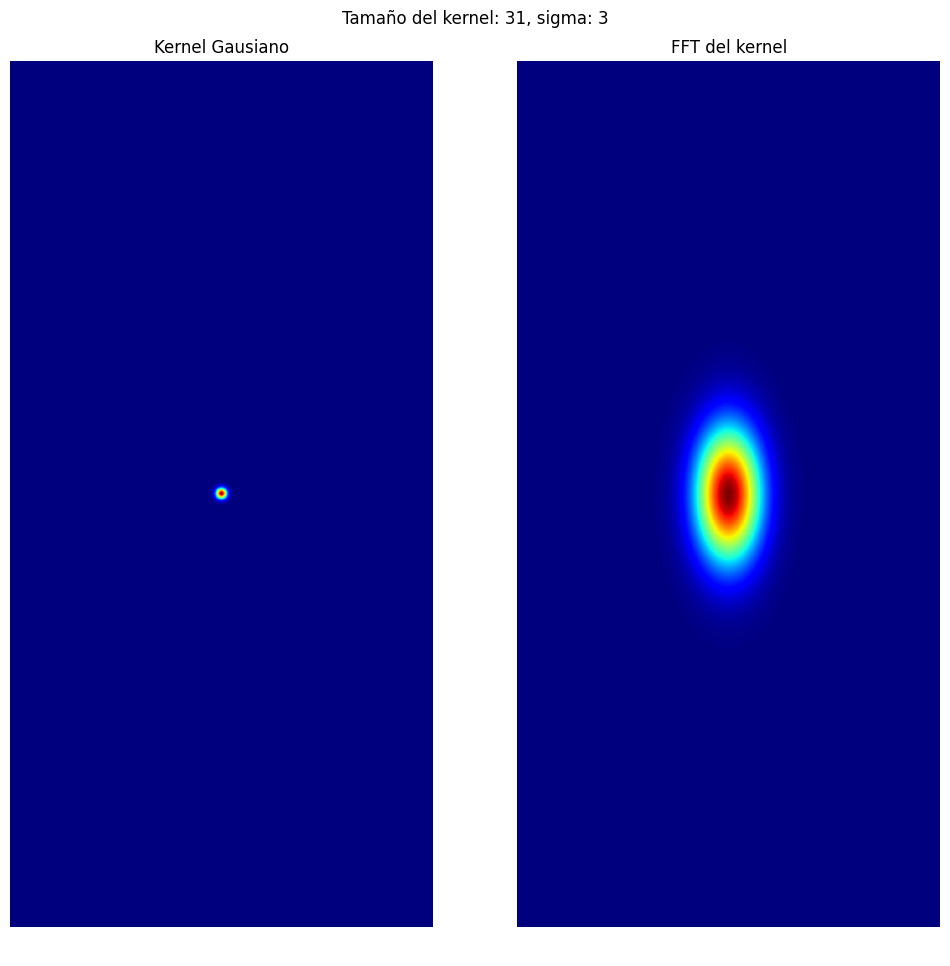

In [87]:
k_sizes = [1,3,5,7,9,15,25,31]
sigma = 3
for ks in k_sizes:
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=ks, sigma=sigma)

    plt.figure(figsize=(12,12))
    plt.title(f"Tamaño del kernel: {ks}, sigma: {sigma}")
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("Kernel Gausiano")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title("FFT del kernel")
    plt.imshow(np.abs(kernel_tf), cmap='jet')

Dado que el filtro gaussiano es un filtro pasa-bajos usado para reducir el ruído causado por componentes de alta frecuencia, se observa que cuanto mayor es el tamaño del kernel, menos frecuencias son permitidas, lo que se refleja en una reducción del tamaño del patrón de circunferencias en los gráficos de FFT del kernel. Por este motivo, un kernel de tamaño 1, dejará pasar todas las frecuencias de una imagen.

Para validar lo anterior, varios kernel de diferentes tamaños se aplican a continuación sobre la imagen cargada:

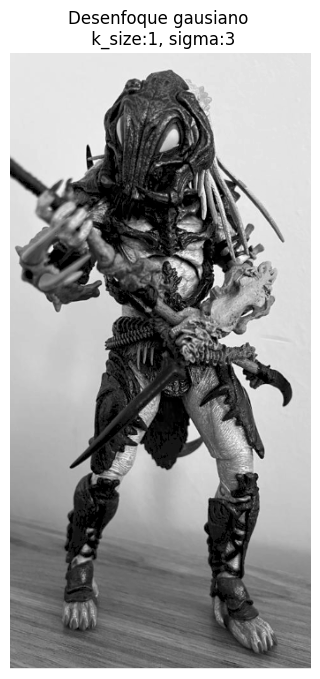

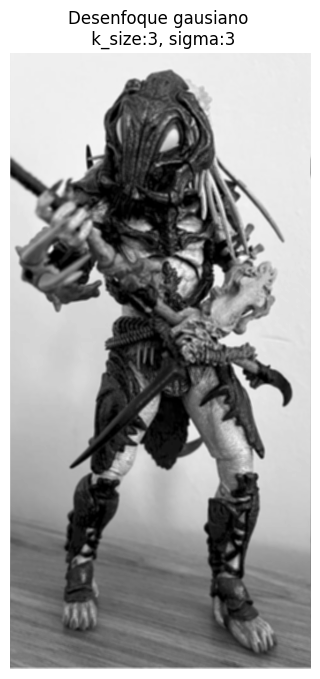

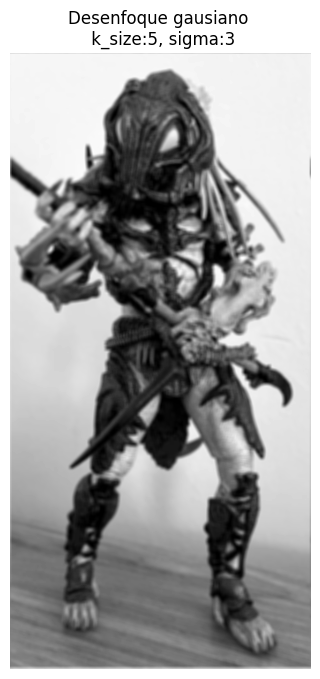

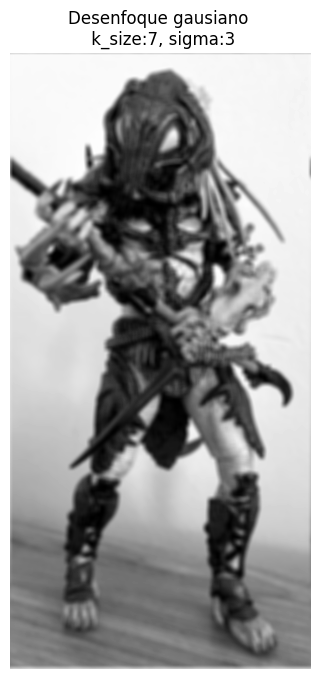

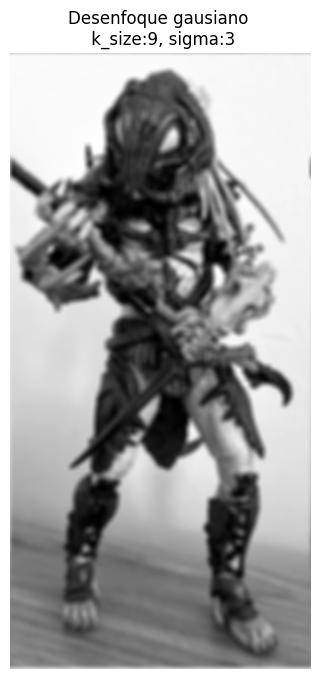

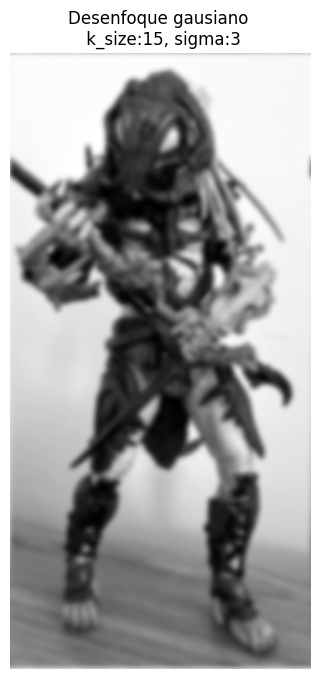

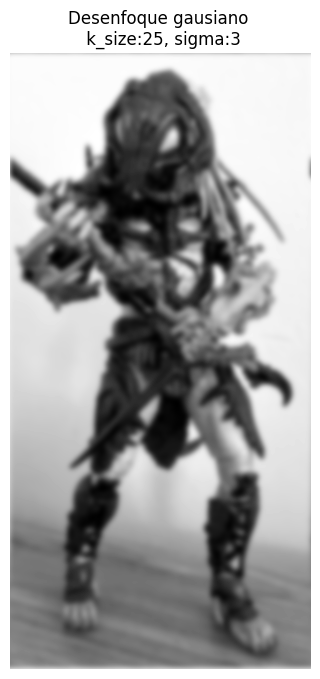

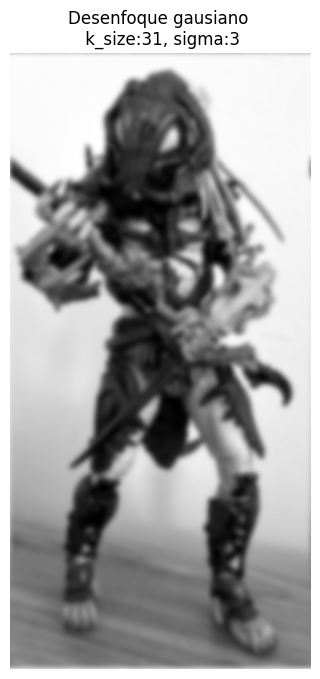

In [88]:
imagesxkernel = []
for ks in k_sizes:
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=ks, sigma=sigma)

    # Calculando la transformada de fourier de la imagen
    img_fft = np.fft.fft2(img)

    # Asegurando que el espectro esté centrado
    img_fft_shifted = np.fft.fftshift(img_fft)

    # Aplicando el filtro gaussiano a través de su transformada
    filtered = img_fft_shifted * kernel_tf

    # Desplazando antes del IFFT
    filtered_ifft = np.fft.ifft2(np.fft.ifftshift(filtered))

    # Tomando la parte real de la antitransformada y centrando
    img_gauss = np.fft.ifftshift(np.real(filtered_ifft))

    # Guardando las imágenes tratadas para uso futuro
    imagesxkernel.append(img_gauss)

    # Visualizando las imágenes
    plt.figure(figsize=(8,8))
    plt.imshow(img_gauss, cmap='gray')
    plt.axis('off')
    plt.title(f'Desenfoque gausiano \n k_size:{ks}, sigma:{sigma}')

Los resultados muestran que cuanto mayor es el tamaño  del kernel, mayor es el efecto de difuminado. Además, un kernel de tamaño 1 no tiene efecto sobre la imagen, como se mencionó anteriormente.

A continuación se presenta el filtro Gaussiano (izquierda) y su transformada de Fourier (FFT, derecha) para diferentes sigmas:

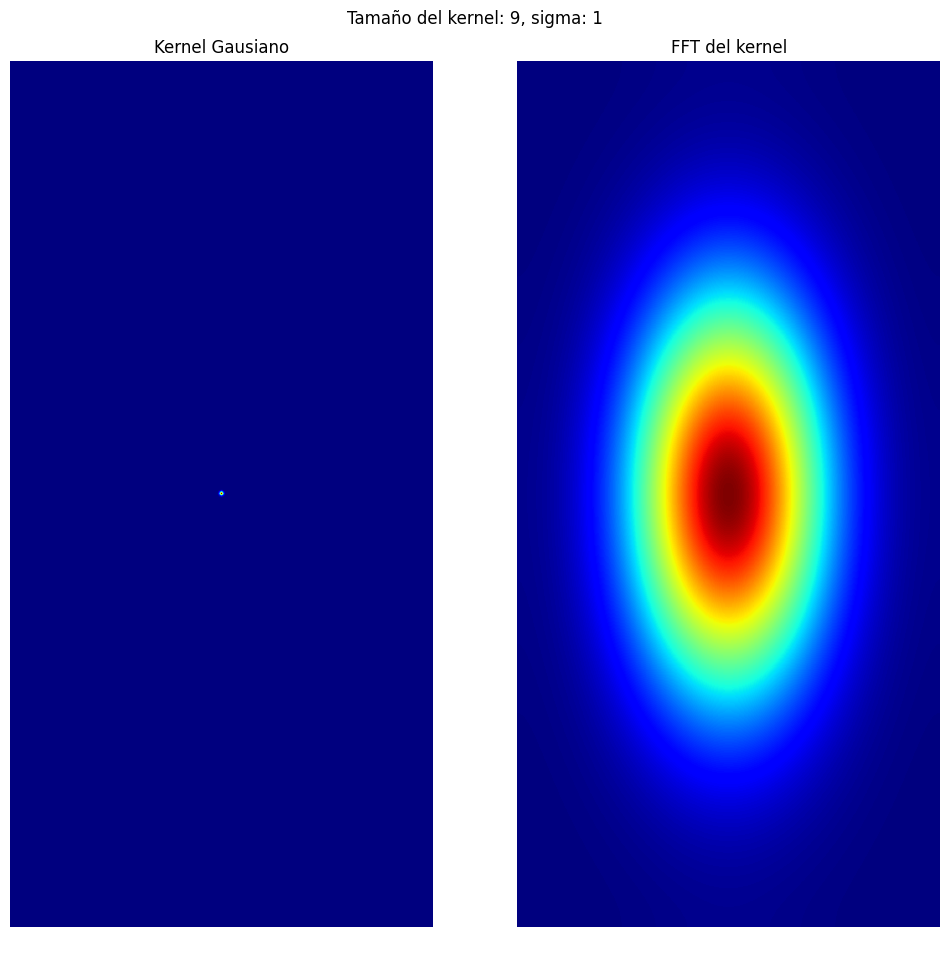

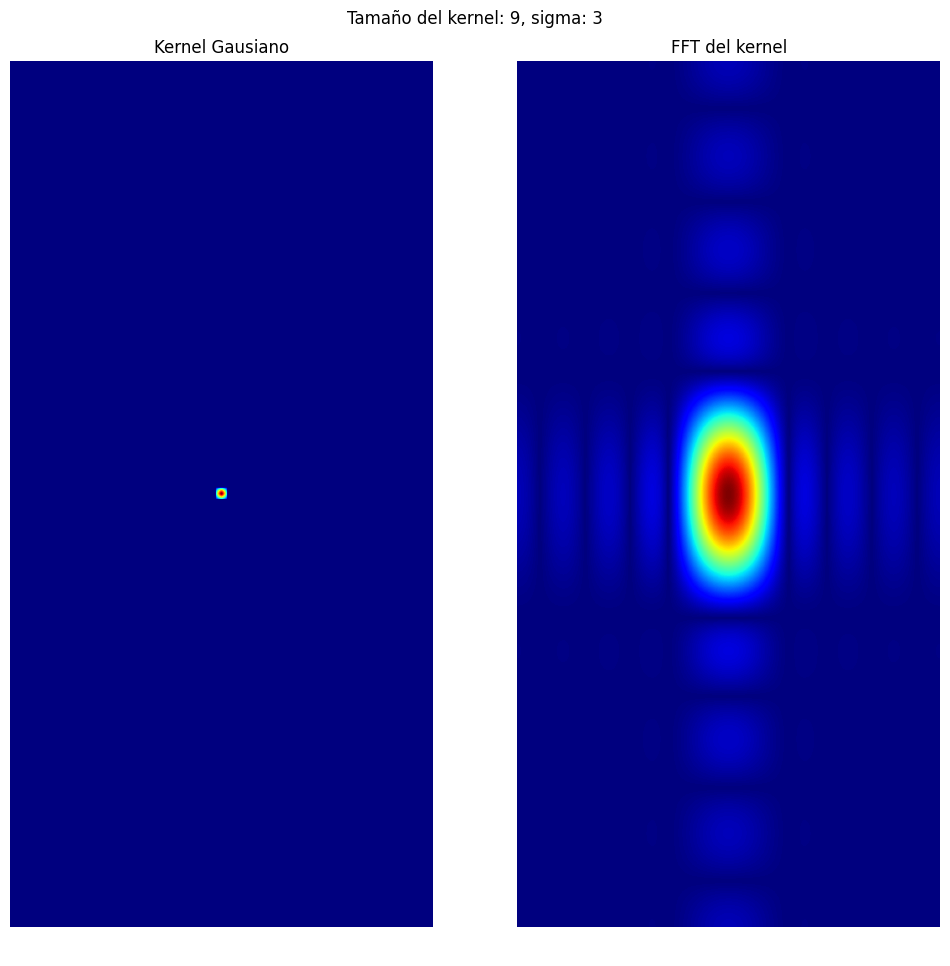

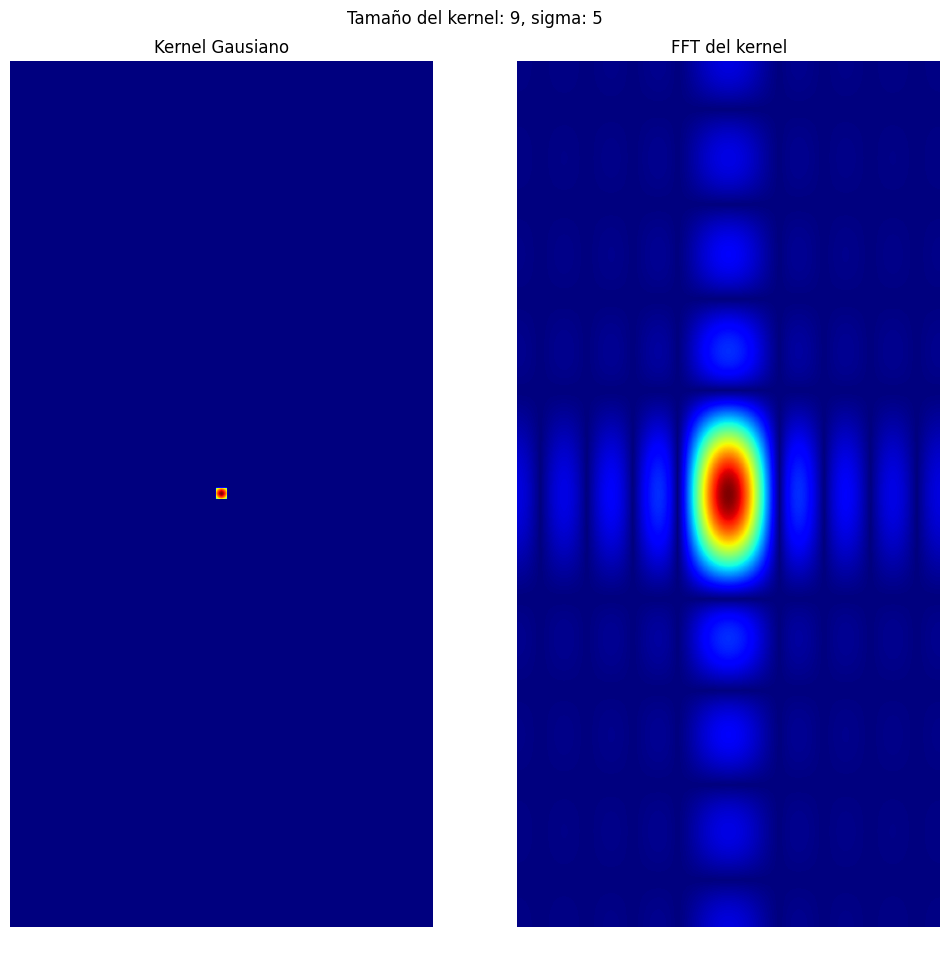

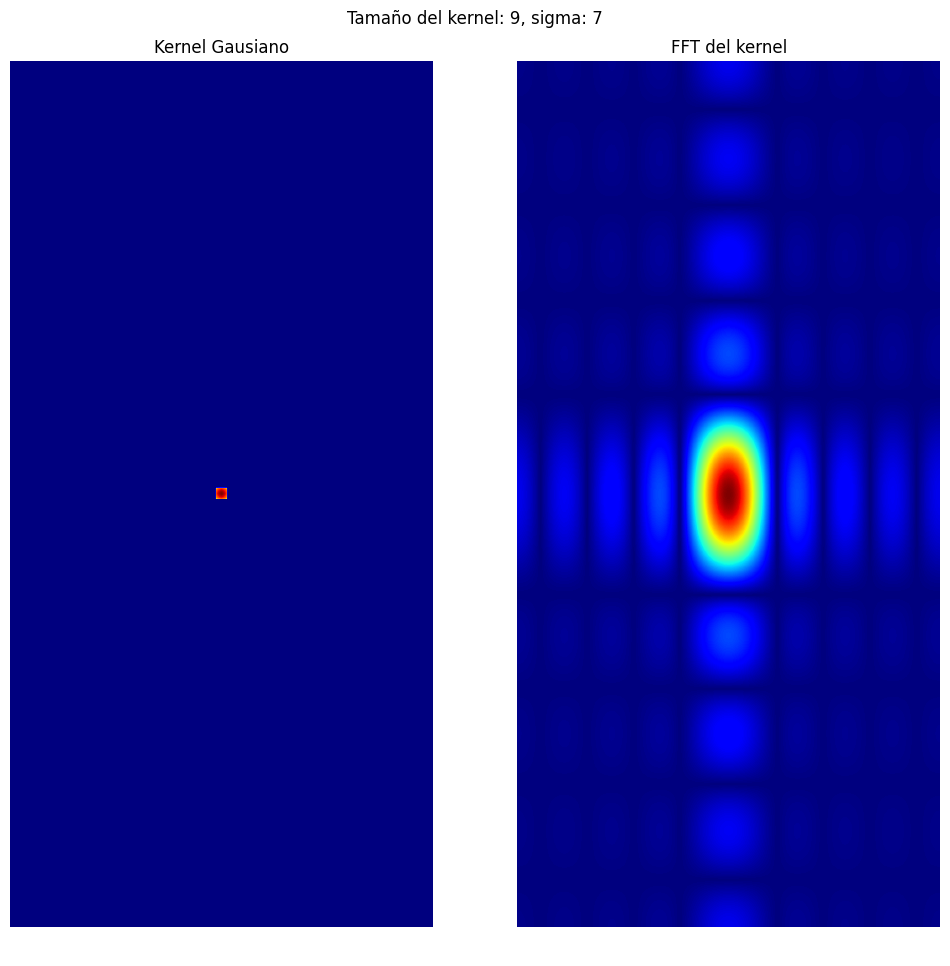

In [52]:
sigmas = [1,3,5,7]
k_size = 9
for s in sigmas:
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=k_size, sigma=s)

    plt.figure(figsize=(12,12))
    plt.title(f"Tamaño del kernel: {k_size}, sigma: {s}")
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("Kernel Gausiano")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title("FFT del kernel")
    plt.imshow(np.abs(kernel_tf), cmap='jet')

Al aumentar sigma se observa que el tamaño del kernel se ve afectado aunque k_size se mantenga constante. Esto se debe a que al aumentar sigma, el ancho de la campana gaussiana aumenta y por lo tanto más píxeles lejanos tendrán un efecto mayor en el resultado. Como consecuencia, se espera que un aumento en sigma genere un suavizado más pronunciado.

Para validar el efecto de sigma, se aplican a continuación varios kernel con diferentes sigmas sobre la imagen original:

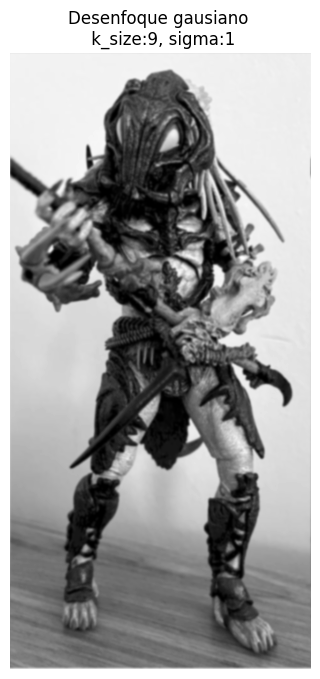

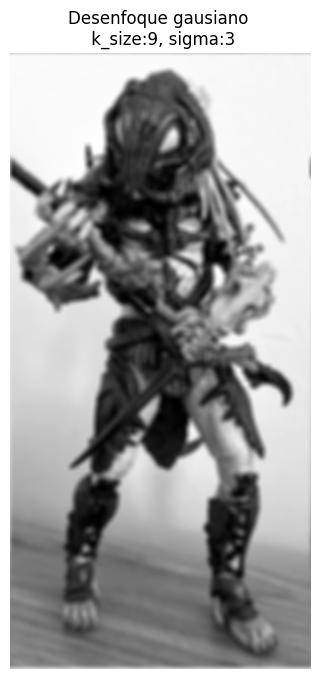

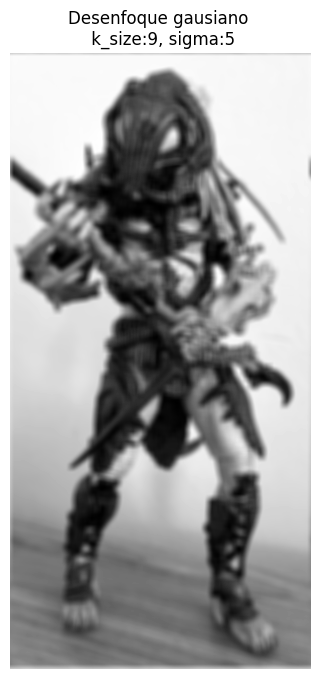

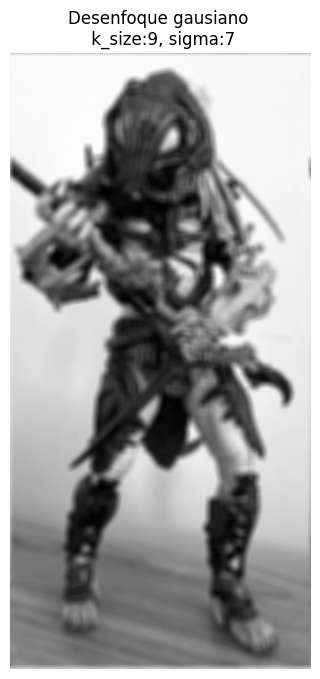

In [53]:
imagesxsigma = []
for s in sigmas:
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=k_size, sigma=s)

    # Calculando la transformada de fourier de la imagen
    img_fft = np.fft.fft2(img)

    # Asegurando que el espectro esté centrado
    img_fft_shifted = np.fft.fftshift(img_fft)

    # Aplicando el filtro gaussiano a través de su transformada
    filtered = img_fft_shifted * kernel_tf

    # Desplazando antes del IFFT
    filtered_ifft = np.fft.ifft2(np.fft.ifftshift(filtered))

    # Tomando la parte real de la antitransformada y centrando
    img_gauss = np.fft.ifftshift(np.real(filtered_ifft))

    # Guardando las imágenes tratadas para uso futuro
    imagesxsigma.append(img_gauss)

    # Visualizando las imágenes
    plt.figure(figsize=(8,8))
    plt.imshow(img_gauss, cmap='gray')
    plt.axis('off')
    plt.title(f'Desenfoque gausiano \n k_size:{k_size}, sigma:{s}')

Como se esperaba, a medida que aumenta sigma, el filtro se hace más ancho, lo que significa que más píxeles circundantes afectan a cada píxel en la imagen filtrada. En consecuencia, la capacidad del filtro para preservar detalles finos disminuye, ya que los bordes y contrastes sutiles se vuelven más difusos.

## 2. Filtrado espectral vs Filtrado por convolucion I

En esta sección se compararán las imágenes obtenidas anteriormente después de aplicar el filtro gaussiano para diferentes tamaños de kernel, con los resultados generados despues de aplicar el filtro por convolución por medio de la función **GaussianBlur** de OpenCV. El objetivo es determinar cuáles son las diferencias de aplicar filtros espectrales (como en el primer caso) en relación con filtros espaciales o de convolución.

La comparación se hará calculando la calidad de las imágenes, como se describe en el artículo *[Image Sharpness Measure for Blurred Images in Frequency Domain](https://www.sciencedirect.com/science/article/pii/S1877705813016007)*, Kanjar De and V. Masilamani, Procedia Engineering 64 (2013) 149 – 158, Sección 3.

Se inicia entonces, filtrando las imágenes por el método de convolución para diferentes tamaños de kernel:

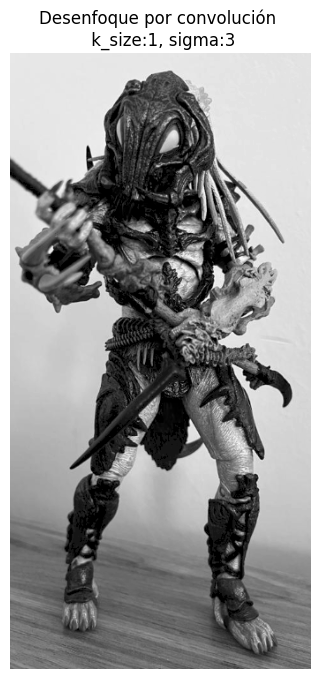

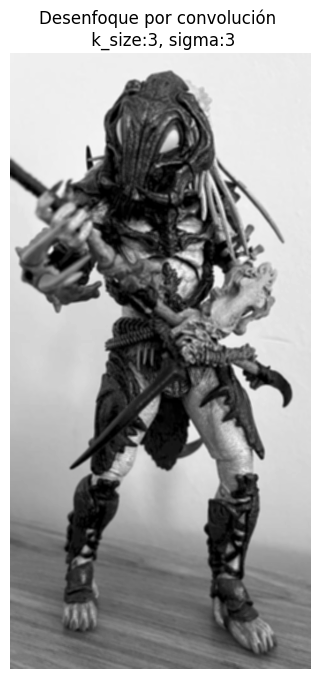

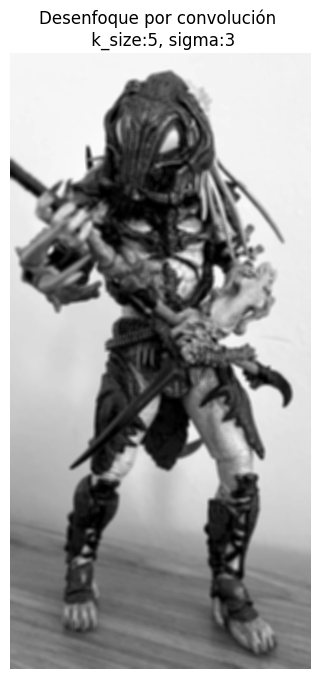

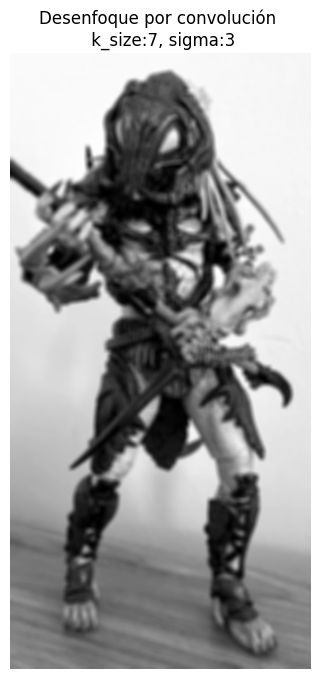

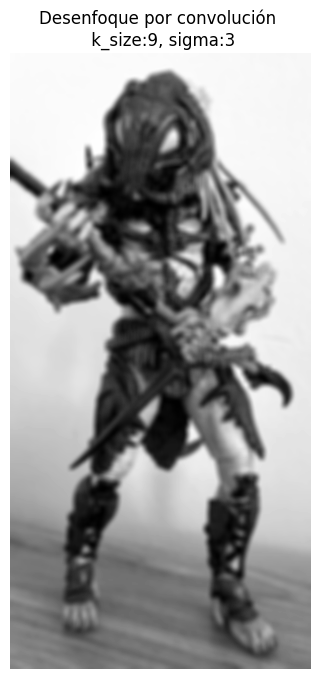

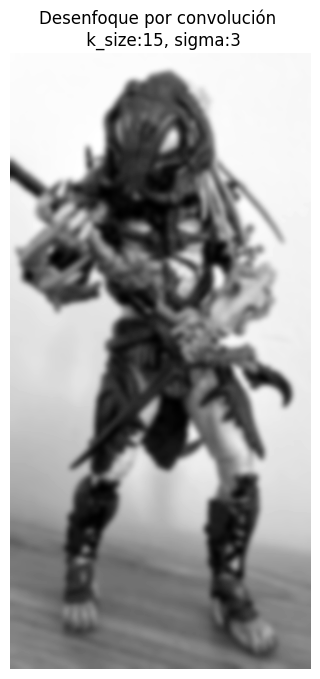

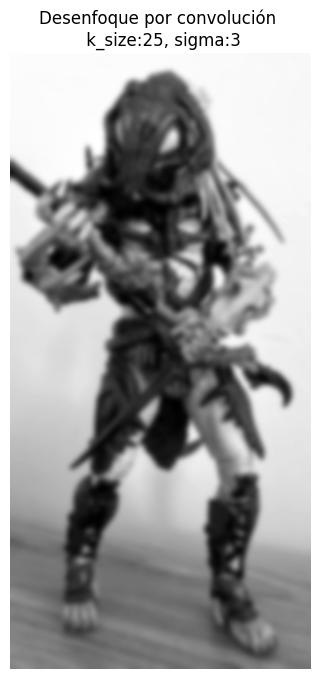

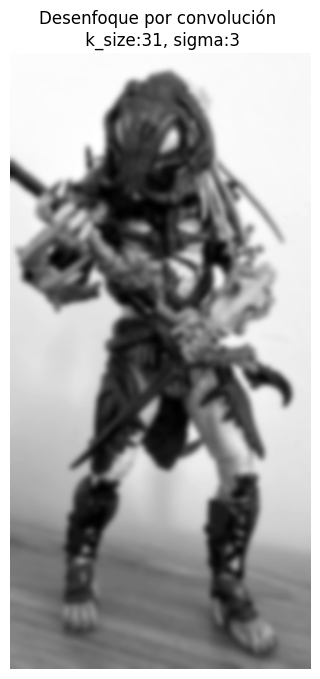

In [89]:
conv_images = []
for ks in k_sizes:    
    # Aplicando el filtro Gaussiano
    conv_image = cv.GaussianBlur(img, ksize=(ks, ks), sigmaX=sigma,  sigmaY=sigma)

    # Guardando las imágenes tratadas para uso futuro
    conv_images.append(conv_image)

    # Visualizando las imágenes
    plt.figure(figsize=(8,8))
    plt.imshow(conv_image, cmap='gray')
    plt.axis('off')
    plt.title(f'Desenfoque por convolución \n k_size:{ks}, sigma:{sigma}')


Se define ahora la función que permitirá calcular la medida de la calidad de la imagen, siguiendo el algoritmo propuesto en el artículo citado anteriormente:

In [56]:
def image_quality(image:np.ndarray) -> float:
    """
    Calculo de la calidad de una imagen
    ----------
    Parámetros
    ----------
    image:np.ndarray 
        Imagen a ser tratada
    
    ----------
    Respuesta
    ----------
    FM:float
        Medida de la calidad de la imagen donde FM significa Frequency Domain Image Blur Measure
    """
    M, N = image.shape  # Tamaño de la imagen
    
    # Paso 1: Calculando la Transformada de Fourier de la imagen
    F = np.fft.fft2(image)
    
    # Paso 2: Desplazando el origen de F al centro
    Fc = np.fft.fftshift(F)
    
    # Paso 3: Calculando AF, el valor absoluto de la transformada de Fourier centrada
    AF = np.abs(Fc)
    
    # Paso 4: Calculando M, el valor máximo en AF
    maximum = np.max(AF)
    
    # Paso 5: Calculando TH, el número total de píxeles en F cuyo valor > thres
    thres = maximum / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calculando FM, la medida de calidad de la imagen
    FM = TH / (M * N)
    
    return FM

Las calidades de las imágenes generadas con cada tipo de filtro son calculadas aquí y comparadas en el dataframe resultante:

Tamaño del Kernel  Calidad Filtro Espectral  Calidad Filtro de Convolución  \
0                  1                  0.036489                       0.036489   
1                  3                  0.028674                       0.029061   
2                  5                  0.021994                       0.022641   
3                  7                  0.017566                       0.018314   
4                  9                  0.014684                       0.015465   
5                 15                  0.011524                       0.012432   
6                 25                  0.011222                       0.012188   
7                 31                  0.011222                       0.012188   

   Diferencia Relativa (%)        Comparacion  
0                 0.000000            Iguales  
1                -1.330056  Mejor Convolución  
2                -2.857673  Mejor Convolución  
3                -4.083505  Mejor Convolución  
4                -5.052975  Mejor Convolución  
5                -7.299763  Mejor Convolución  
6                -7.928301  Mejor Convolución  
7                -7.928301  Mejor Convolución

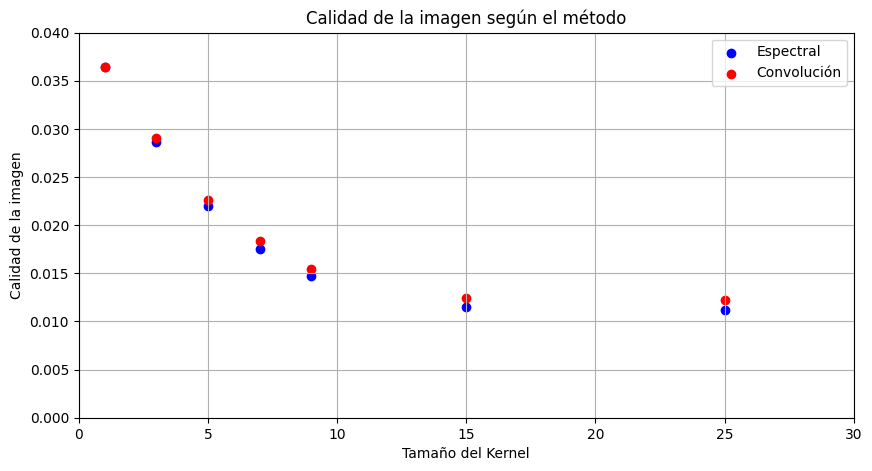

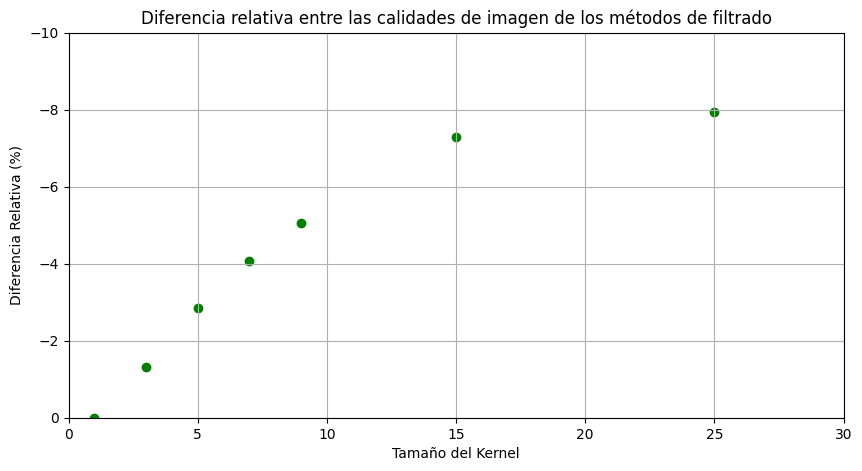

In [103]:
# Calculando la calidad de imagen para las imágenes generadas con filtro espectral
spectral_qualities = []
for i in imagesxkernel:
    quality = image_quality(i)
    spectral_qualities.append(quality)

# Calculando la calidad de imagen para las imágenes generadas con filtro espacial
spacial_qualities  = []
for j in conv_images:
    quality = image_quality(j)
    spacial_qualities.append(quality)

# Creando un DataFrame para comparar los resultados
df = pd.DataFrame(k_sizes, columns=['Tamaño del Kernel'])
df["Calidad Filtro Espectral"] = spectral_qualities
df["Calidad Filtro de Convolución"]  = spacial_qualities
df["Diferencia Relativa (%)"]  = (df["Calidad Filtro Espectral"] - df["Calidad Filtro de Convolución"]) * 100 / df["Calidad Filtro de Convolución"]
df["Comparacion"] = np.where(df['Calidad Filtro Espectral'] > df['Calidad Filtro de Convolución'], 'Mejor Espectral',
                             np.where(df['Calidad Filtro Espectral'] < df['Calidad Filtro de Convolución'], 'Mejor Convolución', 'Iguales'))
display(df)

# Creando un gráfico de dispersión para ver el efecto del tamaño del kernel en la calidad de la imagen
plt.figure(figsize=(10, 5))
plt.scatter(df['Tamaño del Kernel'], df['Calidad Filtro Espectral'], label='Espectral', color='blue')
plt.scatter(df['Tamaño del Kernel'], df['Calidad Filtro de Convolución'],  label='Convolución', color='red')
plt.title('Calidad de la imagen según el método')
plt.xlabel('Tamaño del Kernel')
plt.ylabel('Calidad de la imagen')
plt.xlim([0, 30])
plt.ylim([0, 0.04])
plt.legend()
plt.grid(True)
plt.show()

# Creando un gráfico de dispersión para ver la diferencia entre los métodos
plt.figure(figsize=(10, 5))
plt.scatter(df['Tamaño del Kernel'], df['Diferencia Relativa (%)'], color='green')
plt.title('Diferencia relativa entre las calidades de imagen de los métodos de filtrado')
plt.xlabel('Tamaño del Kernel')
plt.ylabel('Diferencia Relativa (%)')
plt.xlim([0, 30])
plt.ylim([0, -10])
plt.grid(True)
plt.show()

Los resultados presentados anteriormente permiten concluir que:
- La calidad de la imagen es inversamente proporcional al tamño del kernel.
- Un kernel de tamaño 1 deja inalterada la imagen original en ambos métodos y por lo tanto la calidad de dicha imagen es 0.036489.
- La calidad de la imagen disminuye rápidamente para tamaños pequeños de kernel, pero tiende a un valor constante para kerneles grandes en ambos métodos. En otras palabras, las imágenes pueden difuminarse hasta un cierto tamaño de kernel, a partir del cual el filtro no tendrá más efecto.
- La diferencia porcentual relativa es directamente proporcional al tamaño del kernel y al ser negativa indica que el filtrado por convolución produce imágenes con mejor calidad que el filtrado espectral.
- No obstante, en este caso la diferencia relativa entre los métodos es pequeña, ya que no supera el 10\%.
- La diferencia entre los métodos puede ser causada debido al manejo de los bordes que implementa la función GaussianBlur de OpenCV y que no se consideró en la función gaussiana diseñada en este trabajo. En este manejo de bordes, GaussianBlur aplica diferentes métodos de extrapolación que ayudan a mejorar el aspecto de la imagen.

## 3. Filtrado espectral vs Filtrado por convolucion II

Finalmente, en esta sección se compararán las imágenes obtenidas luego de aplicar los filtros gaussiano y por convolución para diferentes tamaños de kernel, pero aplicando esta vez el método de contraste descrito en el apéndice del artículo *[Analysis of focus measure operators in shape-from-focus](https://www.sciencedirect.com/science/article/abs/pii/S0031320312004736)*, S. Pertuz, D. Puig, M. A. Garcia, Pattern Recognition 46 (2013) 1415–1432, Sección A.3.

La función para implementar dicho método se define a continuación:

In [130]:
def contrast_quality(image:np.ndarray) -> (np.ndarray, float):
    """
    Calculo de la calidad de una imagen por contraste
    ----------
    Parámetros
    ----------
    image:np.ndarray 
        Imagen a ser tratada
    
    ----------
    Respuesta
    ----------
    contrast_map:np.ndarray
        Mapa de contraste de la imagen

    phi:float
        Contraste acumulado
    """
    # Asegurando que la imagen esté en escala de grises
    if len(image.shape) > 2:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # Creando una matriz de ceros para el mapa de contraste
    M, N = image.shape
    contrast_map = np.zeros((M, N))

    # Calculando el contraste local para cada píxel
    for x in range(1, M-1):
        for y in range(1, N-1):
            central_pixel = image[x, y]
            # Sumando las diferencias absolutas con los vecinos inmediatos
            local_contrast = 0
            for i in range(x-1, x+2):
                for j in range(y-1, y+2):
                    if i == x and j == y:
                        continue  # Salta el píxel central en la suma
                    local_contrast += abs(central_pixel - image[i, j])
            contrast_map[x, y] = local_contrast
    
    # Sumando todos los valores de contraste para obtener la medida de calidad de la imagen
    phi = np.sum(contrast_map)
    
    return contrast_map, phi

Los mapas de contraste y los valores de calidad de imagen para cada una de las imagenes generadas con diferentes tamaños de kernel, son calculados en la siguiente celda:

/var/folders/sz/sjmjp0xj2r35nk_bcvzdc0wc0000gn/T/ipykernel_71281/2394769159.py:37: RuntimeWarning: overflow encountered in scalar subtract
  local_contrast += abs(central_pixel - image[i, j])


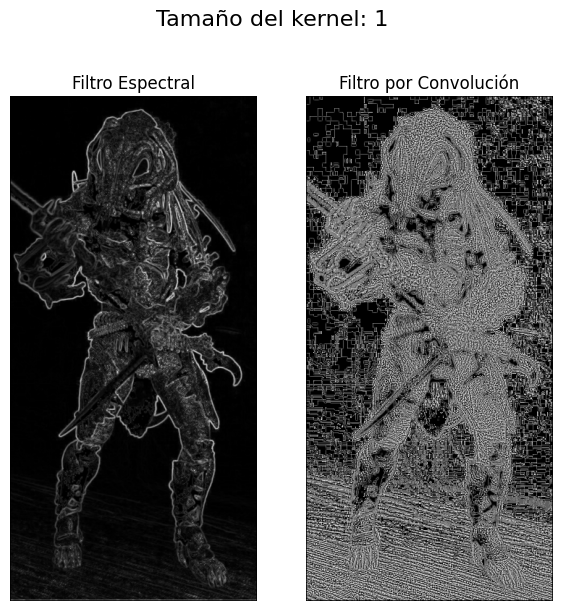

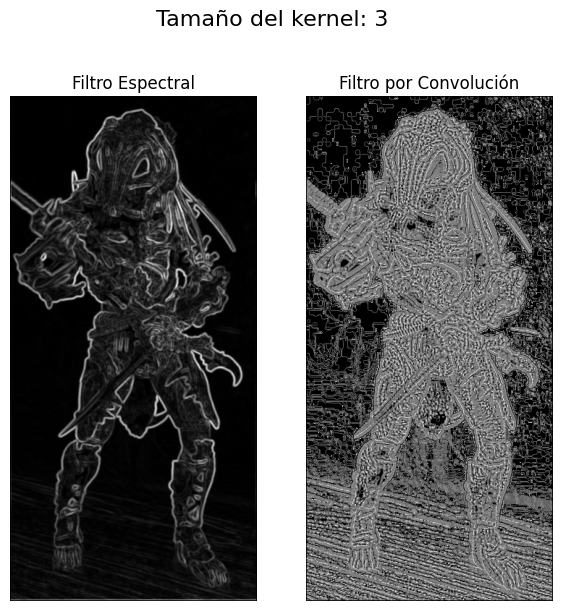

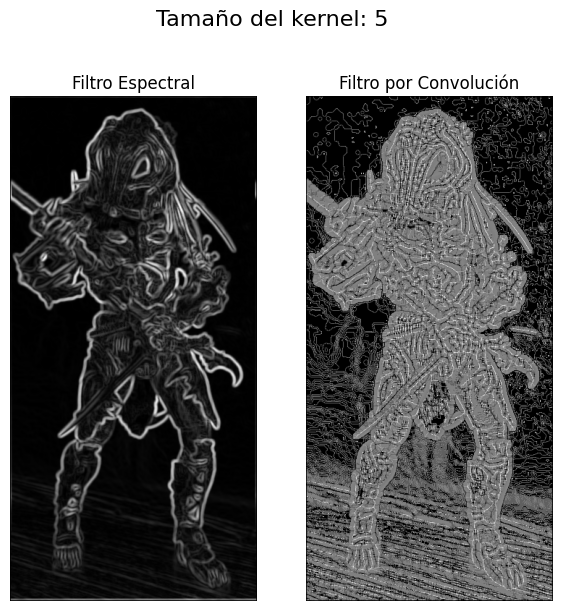

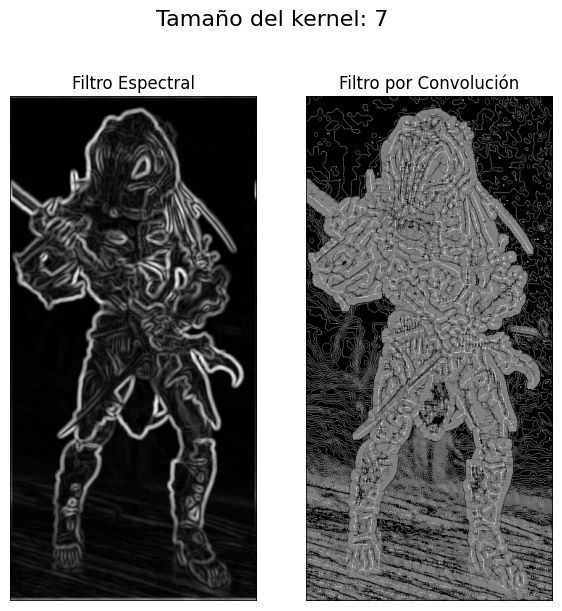

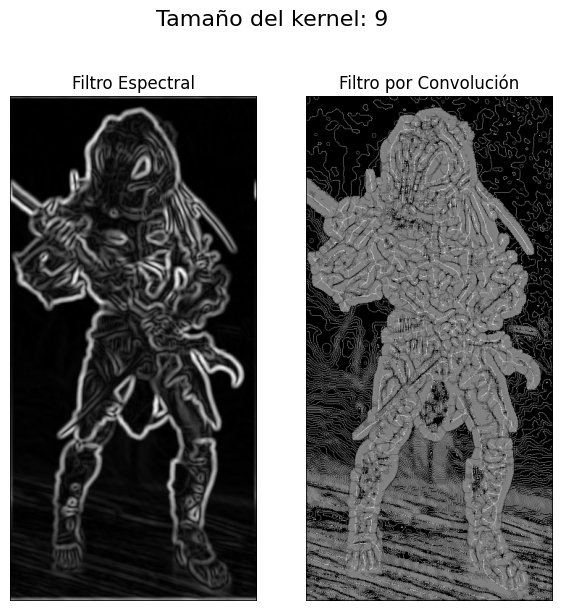

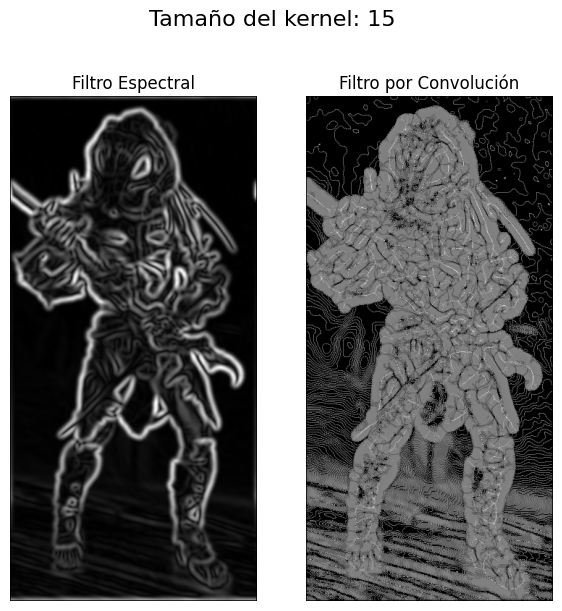

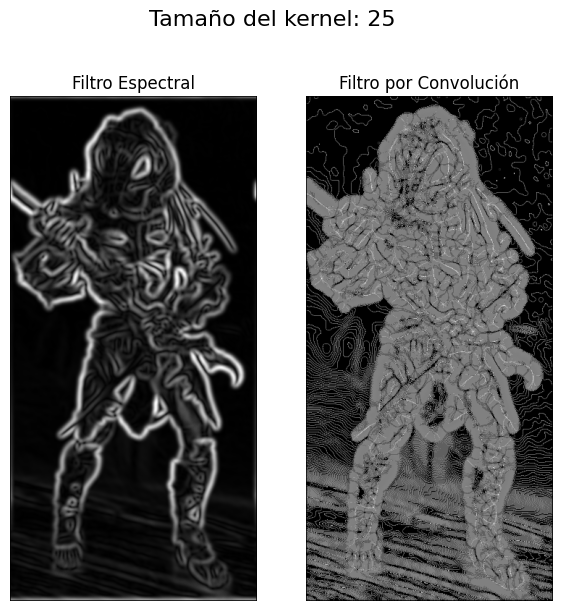

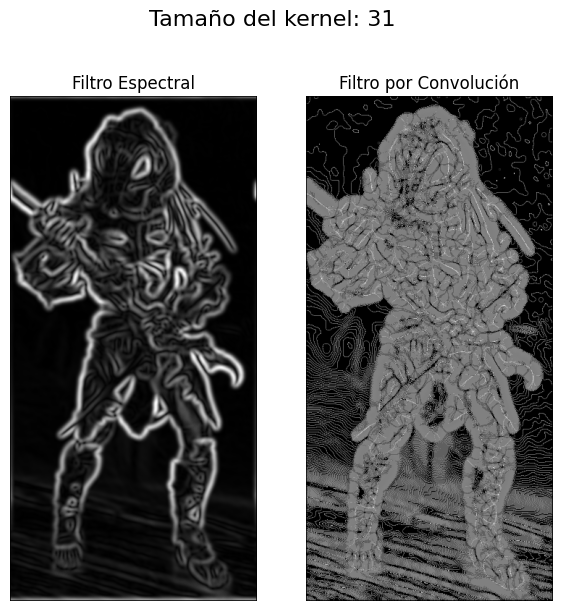

In [129]:
rows = len(imagesxkernel)
spectral_qualities = []
spacial_qualities  = []

# Mostrar las imágenes en 2 columnas y 5 filas
for i in range(rows):
    contrast_map1, quality1 = contrast_quality(imagesxkernel[i])
    contrast_map2, quality2 = contrast_quality(conv_images[i])

    spectral_qualities.append(quality1)
    spacial_qualities.append(quality2)
    
    # Configurando la visualización de las tres imagenes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

    # Ajustando el espacio entre las imágenes
    plt.subplots_adjust(hspace=0.2, wspace=0.2)

    # Mostrando las imágenes
    axs[0].imshow(contrast_map1, cmap='gray')
    axs[0].set_title('Filtro Espectral')
    axs[0].axis('off')

    axs[1].imshow(contrast_map2, cmap='gray')
    axs[1].set_title('Filtro por Convolución')
    axs[1].axis('off')
    
    fig.suptitle(f'Tamaño del kernel: {k_sizes[i]}', fontsize=16)

    plt.show()

La comparación entre los mapas de contraste para el método de filtrado espectral y por convolución, muestra diferencias importantes entre los métodos, ya que el mapa de contraste del filtrado espectral (izquierda) sólo permite apreciar los bordes de la figura de acción, mientras que en el mapa de contraste para el filtrado por convolución (derecha) se aprecia no solo el contorno de la figura, sino también algunos detalles de la superficie donde se encuentra apoyada.

Las diferencia entre los métodos de filtrado se aprecian mejor al comparar la calidad de las imágenes, calculadas como el contraste acumulado:

Tamaño del Kernel  Calidad Filtro Espectral  Calidad Filtro de Convolución  \
0                  1              1.796877e+07                    161218390.0   
1                  3              1.099269e+07                    164991741.0   
2                  5              8.408902e+06                    157774205.0   
3                  7              7.061606e+06                    153719744.0   
4                  9              6.280934e+06                    151198712.0   
5                 15              5.453427e+06                    149169360.0   
6                 25              5.359080e+06                    149266104.0   
7                 31              5.358816e+06                    149266104.0   

   Diferencia Relativa (%)        Comparacion  
0                88.854391  Mejor Convolución  
1                93.337433  Mejor Convolución  
2                94.670294  Mejor Convolución  
3                95.406181  Mejor Convolución  
4                95.845908  Mejor Convolución  
5                96.344137  Mejor Convolución  
6                96.409714  Mejor Convolución  
7                96.409891  Mejor Convolución

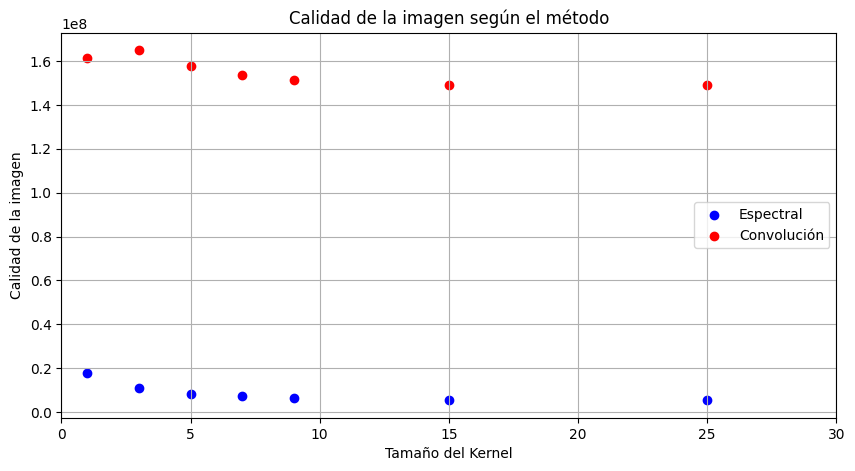

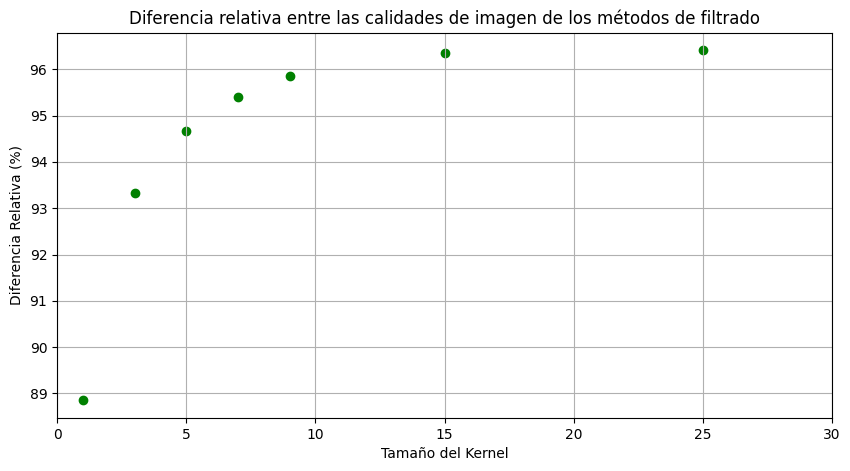

In [131]:
# Creando un DataFrame para comparar los resultados
df = pd.DataFrame(k_sizes, columns=['Tamaño del Kernel'])
df["Calidad Filtro Espectral"] = spectral_qualities
df["Calidad Filtro de Convolución"]  = spacial_qualities
df["Diferencia Relativa (%)"]  = (df["Calidad Filtro de Convolución"] - df["Calidad Filtro Espectral"]) * 100 / df["Calidad Filtro de Convolución"]
df["Comparacion"] = np.where(df['Calidad Filtro Espectral'] > df['Calidad Filtro de Convolución'], 'Mejor Espectral',
                             np.where(df['Calidad Filtro Espectral'] < df['Calidad Filtro de Convolución'], 'Mejor Convolución', 'Iguales'))
display(df)

# Creando un gráfico de dispersión para ver el efecto del tamaño del kernel en la calidad de la imagen
plt.figure(figsize=(10, 5))
plt.scatter(df['Tamaño del Kernel'], df['Calidad Filtro Espectral'], label='Espectral', color='blue')
plt.scatter(df['Tamaño del Kernel'], df['Calidad Filtro de Convolución'],  label='Convolución', color='red')
plt.title('Calidad de la imagen según el método')
plt.xlabel('Tamaño del Kernel')
plt.ylabel('Calidad de la imagen')
plt.xlim([0, 30])
# plt.ylim([0, 0.04])
plt.legend()
plt.grid(True)
plt.show()

# Creando un gráfico de dispersión para ver la diferencia entre los métodos
plt.figure(figsize=(10, 5))
plt.scatter(df['Tamaño del Kernel'], df['Diferencia Relativa (%)'], color='green')
plt.title('Diferencia relativa entre las calidades de imagen de los métodos de filtrado')
plt.xlabel('Tamaño del Kernel')
plt.ylabel('Diferencia Relativa (%)')
plt.xlim([0, 30])
# plt.ylim([0, 3])
plt.grid(True)
plt.show()

Como en el caso de la sección anterior, el primer gráfico muestra que las calidades de las imágenes en ambos métodos de filtrado disminuyen al aumentar el tamaño del kernel.

Sin embargo, el método de contraste indica que incluso para un kernel de tamaño 1, las diferencias entre los métodos de filtrado son considerables, y aumentan con el tamaño del kernel. Nuevamente, el método de convolución de la función GaussianBlur de OpenCV presenta mejores calidades de imagen.

El aumento en la diferencia de las calidades de imagen entre los métodos de filtrado al comparar sus contrastes es una consecuencia de los métodos de optimización empleados por la función GaussianBlur de OpenCV. Dicha función se encuentra altamente optimizada y utiliza implementaciones internas eficientes para el manejo de la convolución y los bordes de la imagen, aspectos que no están presentes en la función create_gauss_filter propuesta en este trabajo.